In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
import pandas as pd

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

input_shape = (224, 224, 3)

In [2]:
mobilenet_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
mobilenet_model.trainable = True
# mobilenet_model.summary()

In [3]:
layers = [(layer, layer.name, layer.trainable) for layer in mobilenet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,True
1,<tensorflow.python.keras.layers.convolutional....,Conv1_pad,True
2,<tensorflow.python.keras.layers.convolutional....,Conv1,True
3,<tensorflow.python.keras.layers.normalization....,bn_Conv1,True
4,<tensorflow.python.keras.layers.advanced_activ...,Conv1_relu,True
...,...,...,...
150,<tensorflow.python.keras.layers.convolutional....,block_16_project,True
151,<tensorflow.python.keras.layers.normalization....,block_16_project_BN,True
152,<tensorflow.python.keras.layers.convolutional....,Conv_1,True
153,<tensorflow.python.keras.layers.normalization....,Conv_1_bn,True


In [4]:
import os
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   zoom_range=0.3, 
                                   rotation_range=50,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

dataset_path = 'dataset'
train_set_path = os.path.join(dataset_path, 'train')
val_set_path = os.path.join(dataset_path, 'test')
BATCH_SIZE = 4
TARGET_SIZE = input_shape[:2]
train_generator = train_datagen.flow_from_directory(train_set_path,
                                                 target_size = TARGET_SIZE,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

val_generator = val_datagen.flow_from_directory(val_set_path,
                                                target_size = TARGET_SIZE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'categorical')
model = Sequential()
model.add(mobilenet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=1,
                               verbose=0,
                               mode='auto')

EPOCHS = 20
history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.n // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=val_generator, 
                    validation_steps=val_generator.n // BATCH_SIZE, 
                    verbose=1,
                    callbacks=[early_stopping])

Found 3061 images belonging to 2 classes.
Found 791 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________
Train for 765 steps, validate for 197 steps
Epoch 1/20
765/765 [==============================] - 67s 88ms/step - loss: 0.2796 - accuracy: 0.8763 - val_loss: 2.1939 - val_accuracy: 0.5863
Epoch 2/20
765/765 [==============================] - 53s 69ms/step - loss: 0.1271 - accuracy: 0.953

In [6]:
model_file_name = 'Fresh_Rotten_Fruits_MobileNetV2_Transfer_Learning'
model.save(model_file_name+'.hdf5')

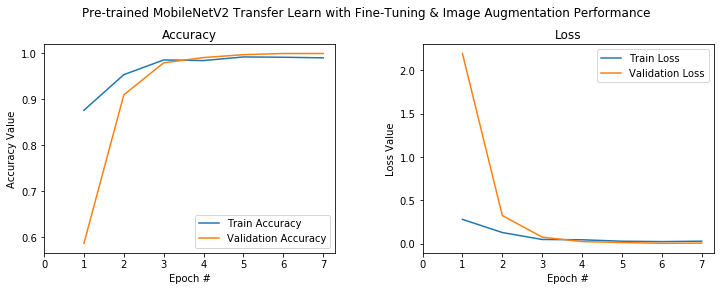

In [8]:
import matplotlib.pyplot as plt
import numpy as np

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained MobileNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,len(history.history['loss'])+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, len(history.history['loss'])+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, len(history.history['loss'])+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")